# Midterm Report 



## Background

Social media has become a new way of communication. It has revolutionized the relationship between users and digital products. The social media users are not only consumers, they are also content (comments) creators and spreaders. A massive amount of data has been generated directly by users and this allows us to measure people’s attention and attitude regarding a product in large scale. 

However, can the social media activities reflect our behaviors in real life?  Previous research showed that the tweets in a critical time period can successfully predict real world outcomes. A study on movie showed that both tweet - rate (number of tweets per hour) and sentiments could predict the box-office revenue (Asur, 2010) and the rating (Oghina,2012) of a particular movie. Also, the overall attitude of tweets has high correlations with people’s behavior in the stock market (Bollen,2011), political elections (Bermingham,2011), and etc.,

However, it may go beyond our expectations in the ways how these social media indicators are correlated with the real world outcomes. For example, products (De Vries,2012) and movies (e.g., [Tiny Times](https://en.wikipedia.org/wiki/Tiny_Times)) that have received negative comments were even more popular than those who received relatively higher ratings in social media. 
In this project, we are interested in how social media is related with users’ behavior in recreational activities. Also, we are curious about how the accuracy affected by factors such as the popularity of the social media and the diversity of information sources. 

Our hypothesis are:
- Both attention and attitude can predict the outcomes. Polarity will cause more attention 
- The popularity of social media and the diversity of information sources positively related with the accuracy.

In this project, we use movie as our subject area because:
- This subject area has research basis, which is both a good foundation of our project and a credible resource for comparing the project results.
- The real world outcomes (purchase behavior) can be easily measured by the box-office revenue.
- The “quality” of a product can be indicated by the IMDb score.




## Data-preparation & analysis

### 1. Movie Box Office Data  
   
   In the data preparation section, the first step of the project is to grasp movie data and twitter data separately:
For the movie data part, the main information we care about are movie’s name, total domestic box office amount (we narrow down the research area for only focus on North America region), movie’s release date, genre, and distributors. The first two features are the main identifier for the movie marked as our label. The third feature (release date) is used for targeting a specific time range for tweets search, and the rest of the features can be used for movie classification since we assume that correlations between twitter and a movie’s box office may also depends on movie’s type.

During the searching for box office data, we found that most of the movie box office information is either not complete or not freely available. There is no public free API available for large scale movie box office query. Therefore, we decide to write web scrapper by ourselves to collect box office data from [Boxoffice-Mojo](www.boxofficemojo.com). Boxoffice-Mojo is a website that tracks box office for more than 16,000 movies, basically, we use [Beautiful Soup](https://www.crummy.com/software/BeautifulSoup/) and python [urllib2](https://docs.python.org/2/library/urllib2.html) library  to do web data scrapping and saved the data into ‘movies_data.pkl’ file. 

In the following code, movie data is exported and sorted by its domestic total gross in decreasing order. The top 5 ranking movies are shown below:


In [85]:
import pickle
import pandas as pd
import numpy as np
import datetime
import unirest
from nltk import compat
import matplotlib.pyplot as plt
import nltk
import sklearn
import string
import csv
import ast
from sklearn.decomposition import TruncatedSVD
from pattern.en import sentiment, parsetree
from glob import glob
from collections import Counter
from get_tweets import get_tweets
from text_classification import process_all, get_rare_words, create_features

In [5]:
with open('movies_data1.pkl', 'r') as picklefile:
    movies_scraped, movies_skipped = pickle.load(picklefile)

In [6]:
movies = pd.DataFrame(movies_scraped)
movies.dropna(axis=0, subset=['domestic_total_gross'], inplace=True)
movies.sort_values(by='domestic_total_gross', ascending=False, inplace=True)

In [101]:
print len(movies)
print movies.dtypes

14682
BOM_id                          object
actors                          object
budget                         float64
director                        object
distributor                     object
domestic_total_gross           float64
genre                           object
movie_title                     object
opening_income_wend            float64
opening_theaters               float64
rating                          object
release_date            datetime64[ns]
runtime_mins                   float64
dtype: object
avatar
jurassicpark4
avengers11
titanic
darkknight
pixar2015
avengers2
batman3
shrek2


We can see that 14,682 movies’ information is dumped from the website and we checked our data by sorting their domestic total box office in descending order. We can see that the top 5 movies are:
* Star War VII        : 936,662,225 
* Avatar              : 749,766,139
* Jurassic Park IV    : 652,270,625
* Avengers II         : 623,357,910
* Titanic             : 600,788,188

It is already verified by other resource which means our data is reliable.
Here is the genre information for the collected movies and their counting distribution:

In [5]:
print movies['genre'].unique()
print movies['genre'].value_counts()

[u'Sci-Fi Fantasy' u'Sci-Fi Adventure' u'Action / Adventure' u'Romance'
 u'Animation' u'Action Thriller' u'Period Adventure' u'Sci-Fi Action'
 u'Fantasy' u'Historical Drama' u'Adventure' u'Action' u'Family Adventure'
 u'Sci-Fi Horror' u'Drama' u'Comedy / Drama' u'Horror' u'Family Comedy'
 u'Comedy' u'Sci-Fi Thriller' u'Horror Thriller' u'Sports Drama'
 u'Sci-Fi Comedy' u'Fantasy Comedy' u'Action Drama' u'Romantic Comedy'
 u'Action Comedy' u'Horror Comedy' u'Sci-Fi' u'Fantasy Drama' u'Thriller'
 u'War' u'Period Action' u'Action Horror' u'Historical Epic' u'Western'
 u'Crime Comedy' u'Adventure Comedy' u'Period Drama' u'Musical'
 u'Sports Comedy' u'Drama / Thriller' u'Crime Drama' u'Foreign / Action'
 u'Period Horror' u'Music Drama' u'Western Comedy' u'Documentary'
 u'War Drama' u'Sports Action' u'Period Comedy' u'Crime' u'Action / Crime'
 u'War Romance' u'IMAX' u'Action Fantasy' u'Crime Thriller'
 u'Romantic Thriller' u'Comedy Thriller' u'Family' u'Romantic Adventure'
 u'Concert' u'Fore

### 2. Twitter comments data
  
  When collecting twitter data, we also met some challenges. Our task is to collect tweets related to a specific film during the time period of the film release. By ‘related to a film’, we use keyword and hashtag search within one tweet. If one tweet contains a film’s name or hash-tag, we regard this tweet as related to this film. Unfortunately, Twitter [streaming API](https://dev.twitter.com/streaming/overview) only allows us to fetch the latest tweets within a week when given keywords and hashtag. Therefore, most of the films’ related tweets which posted earlier than a week cannot be fetched. We also tried several reliable open-sourced twitter data fetching library, since most of them are based on Twitter streaming API so they cannot satisfy our requirement. One of a not-very-popular library is found [here](https://github.com/Jefferson-Henrique/GetOldTweets-python). The basic idea is that when you enter on Twitter page a scroll loader starts, if you scroll down you start to get more and more tweets, all through calls to a JSON provider. After mimic we get the best advantage of Twitter Search on browsers, it can search the deepest oldest tweets. The good thing is that this library can fit most of our requirement, and the bad thing is that it is not a very reliable library due to its popularity, but so far we do not find any side effect or flaws when using this library.
 
Blocks below are codes we used to collect tweets data. Temporarily, we set the max tweets number for each movie to be 1,000. We will adjust this number in the future if the training/testing performance does not go well. Basic features we used for each tweet are its word count, retweet number, and whether it contains links. Besides, we conduct sentimental analysis from a [public API](http://text-processing.com/api/sentiment/). Due to the daily usage limitation for sentimental analysis API, we only choose seven films to do the sentimental analysis here, among the seven movies, four of them are popular movies which have very high box office,while the other threes are relatively normal movies:


In [2]:
time_range = datetime.timedelta(days=45)
maxtweets = 1000

def fetch_tweets(row):
    BOM_id = row['BOM_id']
    movie_title = row['movie_title']
    query = BOM_id + ' OR #' + BOM_id + ' OR ' + movie_title + ' OR #' + movie_title
    date = row['release_date']
    start = date.date().strftime('%Y-%m-%d')
    end = (date.date() + time_range).strftime('%Y-%m-%d')
    try:
        get_tweets(filename='data2/' + BOM_id, maxtweets=maxtweets, query=query, since=start, until=end)
        print movie_title, start, end
    except:
        print "Problem with fetching tweets of" + BOM_id
        return    

In [38]:
# fetched index: 0 ~ 20, 200 ~ 220, 400 ~ 420
start = 400 
end = 420

for _, row in movies.iloc[start:end].iterrows():
    fetch_tweets(row)  

Done. Output file generated "data2/americanbeauty".
American Beauty 1999-09-15 1999-10-30
Done. Output file generated "data2/officerandagentleman".
An Officer and a Gentleman 1982-07-30 1982-09-13
Done. Output file generated "data2/ring".
The Ring 2002-10-18 2002-12-02
Done. Output file generated "data2/nuttyprofessor".
The Nutty Professor 1996-06-28 1996-08-12
Done. Output file generated "data2/borat".
Borat: Cultural Learnings of America for Make Benefit Glorious Nation of Kazakhstan 2006-11-03 2006-12-18
Done. Output file generated "data2/ghostbusters2016".
Ghostbusters 2016-07-15 2016-08-29
Done. Output file generated "data2/secretservice".
Kingsman: The Secret Service 2015-02-13 2015-03-30
Done. Output file generated "data2/robots".
Robots 2005-03-11 2005-04-25
Done. Output file generated "data2/comingtoamerica".
Coming to America 1988-06-29 1988-08-13
Done. Output file generated "data2/crouchingtigerhiddendragon".
Crouching Tiger, Hidden Dragon 2000-12-08 2001-01-22
Done. Output 

In [19]:
fetched_movie = {}
directories = glob('data/*')
print directories
for directory in directories:
    BOM_id = directory[5:]
    print BOM_id
    fetched_movie[BOM_id] = pd.read_csv(directory, sep=';', index_col=0, dtype={'probability':dict})

['data/avatar', 'data/avengers11', 'data/jurassicpark4', 'data/misterlonely', 'data/starwars7', 'data/totalrecall2012rerelease', 'data/womenintrouble']
avatar
avengers11
jurassicpark4
misterlonely
starwars7
totalrecall2012rerelease
womenintrouble


In [20]:
fetched_movie['avatar']['probability']

0      {u'neg': 0.6073704052935256, u'neutral': 0.574...
1      {u'neg': 0.5269049977825001, u'neutral': 0.150...
2      {u'neg': 0.5539897699570541, u'neutral': 0.695...
3      {u'neg': 0.7488556422215029, u'neutral': 0.009...
4      {u'neg': 0.4740998741068114, u'neutral': 0.459...
5      {u'neg': 0.40928057279105023, u'neutral': 0.67...
6      {u'neg': 0.6823311325292117, u'neutral': 0.336...
7      {u'neg': 0.43725030660487463, u'neutral': 0.42...
8      {u'neg': 0.6300027197404761, u'neutral': 0.732...
9      {u'neg': 0.4697837663381408, u'neutral': 0.361...
10     {u'neg': 0.44082652084367824, u'neutral': 0.45...
11     {u'neg': 0.41407483506756737, u'neutral': 0.42...
12     {u'neg': 0.6177381529119155, u'neutral': 0.389...
13     {u'neg': 0.30225597213717326, u'neutral': 0.15...
14     {u'neg': 0.43725030660487463, u'neutral': 0.42...
15     {u'neg': 0.40463664920447306, u'neutral': 0.67...
16     {u'neg': 0.5326637721841756, u'neutral': 0.356...
17     {u'neg': 0.4353802152488

In [19]:
# def sentiment(text):
#     # response = requests.post('http://text-processing.com/api/sentiment/', data={'text': text})
#     response = unirest.post("https://japerk-text-processing.p.mashape.com/sentiment/",
#         headers={
#             "X-Mashape-Key": "EMrBfg9GO4mshgbevq2BtBZCdet3p1iXIWejsnKRDuWRNljYxI",
#             "Content-Type": "application/x-www-form-urlencoded",
#             "Accept": "application/json"
#           },
#         params={
#             "language": "english",
#             "text": text
#           }
#     )
#     if response.code != 200:
#         print response.code
#         print response.body
#         print 'failed: {}'.format(text)
#         return {'sentiment': None, 'probability': None}
#     sentiment = response.body['label']
#     if sentiment == 'pos':
#         return {'sentiment': 1, 'probability': response.body['probability']}
#     elif sentiment == 'neg':
#         return {'sentiment': -1, 'probability': response.body['probability']}
#     else:
#         return {'sentiment': 0, 'probability': response.body['probability']}

In [20]:
# def get_sentiments(movie_dict):
#     for BOM_id, movie in movie_dict.items():
#         sentiments = pd.DataFrame([sentiment(text) for text in movie['text']])
#         movie_dict[BOM_id] = pd.concat([movie, sentiments], axis=1)
#         #movie.to_csv('data/' + BOM_id, sep=';')
#         print BOM_id

In [21]:
# def ouput_csv(movie_dict):
#     for BOM_id, movie in movie_dict.items():
#         movie.to_csv('data/' + BOM_id, sep=';')

From the following result we can see that, according to the sample we collected, popular movies tend to have more positive reviews and more tweets and retweets amount as a whole. More detailed research and their correlation will be studied after midterm report.

In [22]:
# for title, movie in fetched_movie.items():
#     counter = Counter(movie['sentiment'])
#     print title, " : ", counter, 'total: ', sum(counter.values())

starwars7  :  Counter({0.0: 650, 1.0: 335, -1.0: 11, nan: 1, nan: 1}) total:  998
avengers11  :  Counter({1: 777, 0: 183, -1: 39}) total:  999
womenintrouble  :  Counter({0: 370, 1: 192, -1: 113}) total:  675
misterlonely  :  Counter({0: 16, 1: 16, -1: 6}) total:  38
totalrecall2012rerelease  :  Counter({-1: 635, 1: 253, 0: 111}) total:  999
avatar  :  Counter({1: 467, 0: 287, -1: 246}) total:  1000
jurassicpark4  :  Counter({0: 481, 1: 334, -1: 185}) total:  1000


# Feature Extraction

Current Idea: Extract features from raw text but also try to reduce feature space.
1. Create parse tree and lemmatize each tweet.
2. Keep nouns, adjectives, and verbs.
3. Create word count, DF-IDF, sentiment, and length features
4. (If needed) use latent semantics analysis (i.e. Trucated SVD)
5. Add gaussian noise to response values

In [39]:
directories = glob('data2/*')

In [33]:
avatar = pd.read_csv("data2/avatar", sep='","', engine='python')
avenger = pd.read_csv("data2/avengers2", sep='","', engine='python')

In [25]:
def clean(text):
    _text = text.lower()
    for char in string.punctuation:
        _text = _text.replace(char, " ")
    return _text

# create features for the 'text' column in df
def get_features(df):
    trees = [parsetree(clean(text), lemmata=True)[0] for text in df['text']]
    processed_tweets = df.assign(text=[
        [word.lemma for word in tree if word.tag.startswith(('JJ', 'NN', 'VB', '!'))] # only keep verbs, noun, adjective
        for tree in trees
    ])
    rare_words = get_rare_words(processed_tweets) # get rare words
    lengths = [len(tweet) for tweet in processed_tweets['text']] # get length of words remaining
    sentiments = [sentiment(tweet)[0] for tweet in processed_tweets['text']] # get sentiment -1.0 ~ 1.0
    # create TfidfVectorizer, CountVectorizer and corresponding feature matrix
    tfidf, X_tfidf, count, X_count = create_features(processed_tweets, rare_words) 
    return tfidf, X_tfidf, count, X_count, lengths, sentiments


In [21]:
# combine multiple data frames into one by combining all texts in a data frame into one string
def combine_df(dfs):
    X = pd.DataFrame()
    text = []
    for df in dfs:
        text.append(' '.join(df['text']))
    return X.assign(text=text)

In [22]:
combined_df = combine_df([avatar, avenger])

In [26]:
features = get_features(combined_df)

In [32]:
features

(TfidfVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
         dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
         lowercase=True, max_df=1.0, max_features=None, min_df=1,
         ngram_range=(1, 1), norm=u'l2', preprocessor=None, smooth_idf=True,
         stop_words=[u'i', u'me', u'my', u'myself', u'we', u'our', u'ours', u'ourselves', u'you', u'your', u'yours', u'yourself', u'yourselves', u'he', u'him', u'his', u'himself', u'she', u'her', u'hers', u'herself', u'it', u'its', u'itself', u'they', u'them', u'their', u'theirs', u'themselves', u'what', u'w... u'\u201din', u'\u2193', u'\u2202', u'\u30c4', u'\u672c\u65e5\u306e\u5e30\u5b85song', u'\U000fe330'],
         strip_accents=None, sublinear_tf=False,
         token_pattern=u'(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
         vocabulary=None),
 <2x1278 sparse matrix of type '<type 'numpy.float64'>'
 	with 1741 stored elements in Compressed Sparse Row format>,
 CountVectorizer(analyzer=u

In [67]:
# Latent Semantic Analysis (Trucated SVD) reduce dimension of feature matrix
svd_tfidf = TruncatedSVD(n_components=10, n_iter=7, random_state=42)
svd_count = TruncatedSVD(n_components=10, n_iter=7, random_state=42)
svd_tfidf.fit(features[1])
svd_count.fit(features[3])

TruncatedSVD(algorithm='randomized', n_components=10, n_iter=7,
       random_state=42, tol=0.0)

In [36]:
# percentage of variance explained
# print(svd_tfidf.explained_variance_ratio_.sum()) 
# print(svd_count.explained_variance_ratio_.sum())

In [75]:
fetched_movie = {}
directories = glob('data/*')
# print directories
for directory in directories:
    BOM_id = directory[5:]
#     print BOM_id
    fetched_movie[BOM_id] = pd.read_csv(directory, sep=';', index_col=0)
    
    
def clean(text):
    _text = text.lower()
    for char in string.punctuation:
        _text = _text.replace(char, " ")
    return _text

def feature_extraction(BOM_id, df, movie):
    df['date'] = pd.to_datetime(df['date'])
    
    def convert(x):
        if type(x) != str:
            return {'pos':0.0, 'neg':0.0, 'neutual':0.0}
        return eval(x)
    
    df['probability'] = df['probability'].apply(convert)
    
    
#     release_time = movie[movie['BOM_id']==BOM_id]['release_date'].iloc[0]
#     two_month_before_release = release_time - np.timedelta64(2, 'M')
#     one_month_after_release = release_time + np.timedelta64(1, 'M')
        
#     critical_tweet = df[(df['date'] > two_month_before_release) & (df['date'] < one_month_after_release)]
    # not possible to get critica_tweet with current data
    # for example, for avatar, it's release on 2009-12-18 and all the tweets collected are posted on 2010-01-31
    # so the following three treat all tweets as critical tweets
    
    critical_tweet = df
    critical_tweet_count = critical_tweet.shape[0]
    critical_tweet_rate = critical_tweet_count / ((df['date'].max() - df['date'].min()).seconds / 3600.0)
    # all the tweets here are all from 2010-01-31 18:04:00 to 2010-01-31 18:59:00 
    critical_tweet_average_length = critical_tweet['text'].apply(lambda x: len(x)).mean()
    
    avg_sentiment = df['sentiment'].mean()
    contrast = df['sentiment'].std()
    
    positive_tweet = df[df['sentiment'] == 1]
    negative_tweet = df[df['sentiment'] == -1]
    polarity = positive_tweet.shape[0] / float(negative_tweet.shape[0])
    polarity_2 = polarity * (df[df['sentiment'] != 0].shape[0] / float(df.shape[0]))
    
    avg_sentiment_prob = df.apply(lambda x: x['probability']['pos'] * (x['sentiment'] == 1) + x['probability']['neg'] * (x['sentiment'] == -1), axis=1).mean()
    polarity_prob = positive_tweet['probability'].apply(lambda x: x['pos']).sum() / negative_tweet['probability'].apply(lambda x: x['neg']).sum()
    
    return np.array([
            critical_tweet_count,
            critical_tweet_rate,
            critical_tweet_average_length,
            avg_sentiment,
            contrast,
            polarity,
            polarity_2,
            avg_sentiment_prob,
            polarity_prob,
        ])
    
# print fetched_movie['avatar'].head()
# feature_extraction('avatar', fetched_movie['avatar'], movies)

# print fetched_movie['avatar'].dtypes

X = np.array([feature_extraction(BOM_id, df, movies) for BOM_id, df in fetched_movie.items()])
y = np.array([movies[movies['BOM_id'] == BOM_id]['domestic_total_gross'].iloc[0] for BOM_id, df in fetched_movie.items()])

[  9.36662225e+08   6.23357910e+08   1.80970000e+04   1.67396000e+05
   1.80810000e+04   7.49766139e+08   6.52270625e+08]


# Prediction
1. Linear Regression
2. Logistic Regression

In [106]:
print len(X), len(y)
P = np.random.permutation(range(len(X)))
tr_end = np.floor(0.75 * len(P))

X_tr, X_eval = X[P[:tr_end],:], X[P[tr_end:],:]
y_tr, y_eval = y[P[:tr_end]], y[P[tr_end:]]

print y_eval

7 7
[  1.80810000e+04   9.36662225e+08]


/Users/muyang/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:5: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/muyang/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:6: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


('Coefficients: \n', array([   305030.90864603,    353818.52810605, -17836434.60954934,
          389877.3118101 ,    -37059.81456209,   9738130.54877   ,
         8260031.06862095,    125560.6613588 ,   9834065.36646382]))
Mean squared error: 77143396009947312.00
Variance score: 0.46


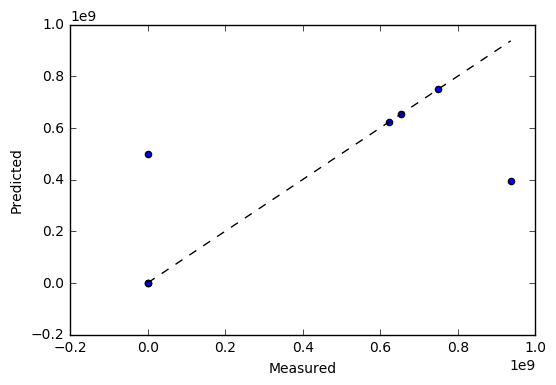

In [107]:
def train_and_eval(X_tr, y_tr, X_eval, y_eval):
    lr = sklearn.linear_model.LinearRegression()
    lr.fit(X_tr,y_tr)
    # The coefficients
    print('Coefficients: \n', lr.coef_)
    # The mean squared error
    print("Mean squared error: %.2f"
          % np.mean((lr.predict(X_eval) - y_eval) ** 2))
    # Explained variance score: 1 is perfect prediction
    print('Variance score: %.2f' % lr.score(X_eval, y_eval))
    # Plot outputs
    fig, ax = plt.subplots()
    ax.scatter(y_eval, lr.predict(X_eval))
    ax.plot([y_eval.min(), y_eval.max()], [y_eval.min(), y_eval.max()], 'k--', lw=1)
    ax.set_xlabel('Measured')
    ax.set_ylabel('Predicted')
    plt.show()
    
train_and_eval(X_tr, y_tr, X, y)

## References
Asur, Sitaram, and Bernardo A. Huberman. "Predicting the future with social media." Web Intelligence and Intelligent Agent Technology (WI-IAT), 2010 IEEE/WIC/ACM International Conference on. Vol. 1. IEEE, 2010.

Bermingham, Adam, and Alan F. Smeaton. "On using Twitter to monitor political sentiment and predict election results." (2011).

Bollen, Johan, Huina Mao, and Xiaojun Zeng. "Twitter mood predicts the stock market." Journal of Computational Science 2.1 (2011): 1-8.

De Vries, Lisette, Sonja Gensler, and Peter SH Leeflang. "Popularity of brand posts on brand fan pages: An investigation of the effects of social media marketing." Journal of Interactive Marketing 26.2 (2012): 83-91.

Oghina, Andrei, et al. "Predicting imdb movie ratings using social media." European Conference on Information Retrieval. Springer Berlin Heidelberg, 2012.